# TF-MoDISco on the TAL GATA simulation

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

TF-MoDISco is using the TensorFlow backend.


3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [11]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]
fwd_activations = f['activations/fwd']
rev_activations = f['activations/rev']
#pad the activations
left_pad = int((len(onehot_data[0]) - fwd_activations.shape[1])/2)
right_pad = int(np.ceil(len(onehot_data[0]) - fwd_activations.shape[1])/2)
padded_fwd_activations = np.concatenate(
    [np.zeros((fwd_activations.shape[0], left_pad, fwd_activations.shape[-1])),
      fwd_activations,
      np.zeros((fwd_activations.shape[0], right_pad, fwd_activations.shape[-1]))], axis=1)
padded_rev_activations = np.concatenate(
    [np.zeros((rev_activations.shape[0], right_pad, rev_activations.shape[-1])),
      rev_activations,
      np.zeros((rev_activations.shape[0], left_pad, rev_activations.shape[-1]))], axis=1)

Double check by plotting

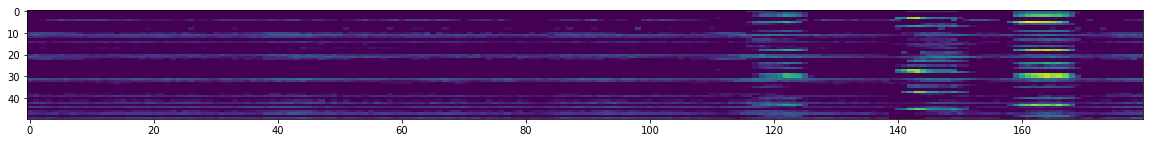

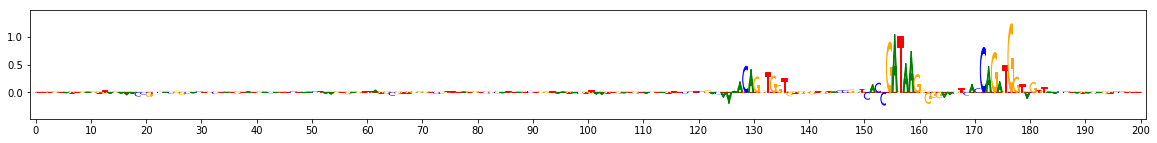

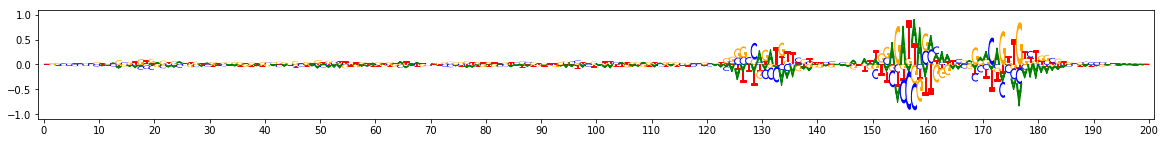

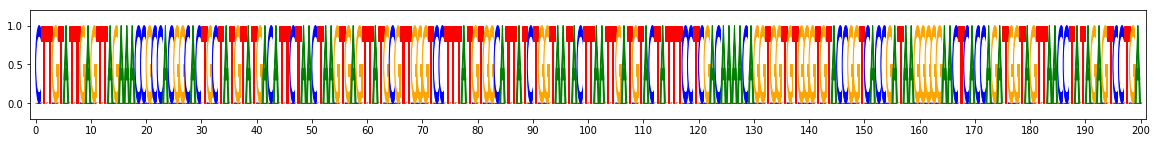

In [22]:
import modisco.visualization
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(fwd_activations[0].transpose(1,0))
ax.set_aspect('auto')
plt.show()
viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=10)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size `sliding_window_size` and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see `examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb` for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that `target_seqlet_fdr`. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.

On task task0
Computing windowed sums on original
Generating null dist


TF-MoDISco is using the TensorFlow backend.


peak(mu)= -0.013692386905662716
Computing threshold
Thresholds from null dist were -1.6740694046020508  and  1.0749762058258057
Final raw thresholds are -1.6740694046020508  and  1.0749762058258057
Final transformed thresholds are -0.891505376344086  and  0.8522513440860215


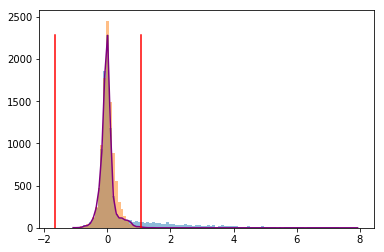

Got 1477 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= 0.007673137664794921
Computing threshold
Thresholds from null dist were -1.7263836562633514  and  0.6461410522460938
Final raw thresholds are -1.7263836562633514  and  0.6461410522460938
Final transformed thresholds are -0.9206317204301075  and  0.8848185483870967


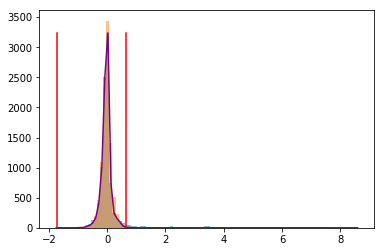

Got 1133 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= 0.00609868049621582
Computing threshold
Thresholds from null dist were -0.6546361446380615  and  0.7163791656494141
Final raw thresholds are -0.6546361446380615  and  0.7163791656494141
Final transformed thresholds are -0.875752688172043  and  0.8803427419354839


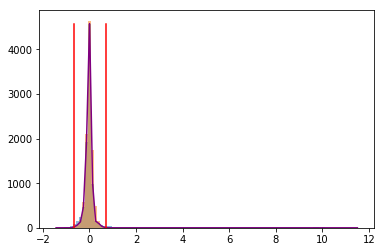

Got 1248 coords
After resolving overlaps, got 2166 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8522512440860216
2166 identified in total
6 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [705, 689, 312, 129, 127, 109]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '1,1,1', 3: '0,1,-1', 4: '0,1,0', 5: '0,0,-1'}
On metacluster 5
Metacluster size 109
Relevant tasks:  ('task2',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 109
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.04 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) C

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.4549400806427002 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished


Wrote graph to binary file in 0.009878158569335938 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.736108
After 2 runs, maximum modularity is Q = 0.780846
Louvain completed 52 runs in 0.6545257568359375 seconds
Preproc + Louvain took 2.161686897277832 s
Got 7 clusters after round 1
Counts:
{4: 13, 3: 13, 1: 16, 6: 7, 0: 20, 5: 11, 2: 14}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 20 seqlets
Trimmed 0 out of 20
Skipped 2 seqlets
Aggregating for cluster 1 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 2 with 14 seqlets
Trimmed 0 out of 14
Skipped 2 seqlets
Aggregating for cluster 3 with 13 seqlets
Trimmed 0 out of 13
Skipped 3 seqlets
Aggregating for cluster 4 with 13 seqlets
Trimmed 1 out of 13
Dropping cluster 4 with 12 seqlets due to sign disagreement
Aggregating for cluster 5 with 11 seqlets
Trimmed 0 out of 11
Skipped 1 seqlets
Aggregating for cluster 6 with 7 seqlets
Trimmed 0 out of 7
Skipped 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.4425678253173828 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished


Wrote graph to binary file in 0.009653806686401367 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78128
Louvain completed 51 runs in 0.6835737228393555 seconds
Preproc + Louvain took 2.1802589893341064 s
Got 8 clusters after round 2
Counts:
{1: 10, 5: 8, 6: 6, 2: 10, 0: 16, 7: 5, 4: 8, 3: 8}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 16 seqlets
Trimmed 1 out of 16
Aggregating for cluster 1 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 2 with 10 seqlets
Trimmed 0 out of 10
Skipped 1 seqlets
Dropping cluster 2 with 9 seqlets due to sign disagreement
Aggregating for cluster 3 with 8 seqlets
Trimmed 1 out of 8
Aggregating for cluster 4 with 8 seqlets
Trimmed 0 out of 8
Aggregating for cluster 5 with 8 seqlets
Trimmed 0 out of 8
Aggregating for cluster 6 with 6 seqlets
Trimmed 0 out of 6
Aggregating for cluster 7 with 5 seqlets
Trimmed 0 out of 5
Got 7 clusters
Splitting into subclusters...
Merging on

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.2961921691894531 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


Wrote graph to binary file in 0.019343137741088867 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.661953
Louvain completed 51 runs in 0.7144582271575928 seconds
Preproc + Louvain took 2.0734620094299316 s
Got 5 clusters after round 1
Counts:
{3: 17, 1: 32, 2: 19, 0: 32, 4: 5}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 32 seqlets
Trimmed 3 out of 32
Skipped 1 seqlets
Aggregating for cluster 1 with 32 seqlets
Trimmed 4 out of 32
Skipped 5 seqlets
Aggregating for cluster 2 with 19 seqlets
Trimmed 3 out of 19
Aggregating for cluster 3 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 4 with 5 seqlets
Trimmed 0 out of 5
(Round 2) num seqlets: 89
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.02 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.6778838634490967 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished


Wrote graph to binary file in 0.017055034637451172 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.757707
Louvain completed 51 runs in 0.6862349510192871 seconds
Preproc + Louvain took 2.431715726852417 s
Got 8 clusters after round 2
Counts:
{1: 15, 5: 7, 0: 18, 7: 4, 4: 12, 6: 5, 2: 14, 3: 14}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 1 with 15 seqlets
Trimmed 1 out of 15
Aggregating for cluster 2 with 14 seqlets
Trimmed 0 out of 14
Skipped 1 seqlets
Aggregating for cluster 3 with 14 seqlets
Trimmed 0 out of 14
Skipped 1 seqlets
Aggregating for cluster 4 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 5 with 7 seqlets
Trimmed 0 out of 7
Aggregating for cluster 6 with 5 seqlets
Trimmed 0 out of 5
Aggregating for cluster 7 with 4 seqlets
Trimmed 0 out of 4
Got 8 clusters
Splitting into subclusters...
Merging on 8 clusters
On merging iteration 1


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.4832699298858643 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


Wrote graph to binary file in 0.026617050170898438 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.730642
Louvain completed 51 runs in 0.7342119216918945 seconds
Preproc + Louvain took 2.2955641746520996 s
Got 7 clusters after round 1
Counts:
{3: 16, 4: 15, 0: 24, 6: 13, 2: 18, 1: 20, 5: 15}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 24 seqlets
Trimmed 0 out of 24
Skipped 4 seqlets
Aggregating for cluster 1 with 20 seqlets
Trimmed 0 out of 20
Skipped 1 seqlets
Aggregating for cluster 2 with 18 seqlets
Trimmed 0 out of 18
Skipped 1 seqlets
Aggregating for cluster 3 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 4 with 15 seqlets
Trimmed 0 out of 15
Skipped 2 seqlets
Aggregating for cluster 5 with 15 seqlets
Trimmed 1 out of 15
Skipped 2 seqlets
Aggregating for cluster 6 with 13 seqlets
Trimmed 0 out of 13
Skipped 1 seqlets
(Round 2) num seqlets: 106
(Round 2) Computing coarse affmat
Beginning embedd

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.4396779537200928 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished


Wrote graph to binary file in 0.017333984375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.707593
After 10 runs, maximum modularity is Q = 0.712126
Louvain completed 60 runs in 0.8222591876983643 seconds
Preproc + Louvain took 2.3286237716674805 s
Got 8 clusters after round 2
Counts:
{4: 16, 1: 19, 2: 17, 6: 4, 0: 26, 3: 16, 5: 6, 7: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 26 seqlets
Trimmed 4 out of 26
Aggregating for cluster 1 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 2 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 3 with 16 seqlets
Trimmed 3 out of 16
Aggregating for cluster 4 with 16 seqlets
Trimmed 4 out of 16
Aggregating for cluster 5 with 6 seqlets
Trimmed 0 out of 6
Aggregating for cluster 6 with 4 seqlets
Trimmed 0 out of 4
Aggregating for cluster 7 with 2 seqlets
Trimmed 0 out of 2
Got 8 clusters
Splitting into subclusters...
Merging on 8 clusters
On merging ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.1745951175689697 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


Wrote graph to binary file in 0.15619611740112305 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.66729
Louvain completed 51 runs in 0.9001560211181641 seconds
Preproc + Louvain took 3.35241961479187 s
Got 5 clusters after round 1
Counts:
{1: 89, 4: 15, 3: 48, 2: 60, 0: 89}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 89 seqlets
Trimmed 8 out of 89
Skipped 15 seqlets
Aggregating for cluster 1 with 89 seqlets
Trimmed 2 out of 89
Skipped 5 seqlets
Aggregating for cluster 2 with 60 seqlets
Trimmed 2 out of 60
Skipped 4 seqlets
Aggregating for cluster 3 with 48 seqlets
Trimmed 2 out of 48
Skipped 7 seqlets
Aggregating for cluster 4 with 15 seqlets
Trimmed 0 out of 15
Skipped 1 seqlets
(Round 2) num seqlets: 255
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.07 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine simi

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.0367817878723145 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


Wrote graph to binary file in 0.11445307731628418 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.672513
Louvain completed 51 runs in 0.8934330940246582 seconds
Preproc + Louvain took 3.160043716430664 s
Got 5 clusters after round 2
Counts:
{1: 66, 0: 74, 3: 47, 2: 55, 4: 13}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 74 seqlets
Trimmed 6 out of 74
Aggregating for cluster 1 with 66 seqlets
Trimmed 0 out of 66
Aggregating for cluster 2 with 55 seqlets
Trimmed 7 out of 55
Aggregating for cluster 3 with 47 seqlets
Trimmed 7 out of 47
Aggregating for cluster 4 with 13 seqlets
Trimmed 0 out of 13
Got 5 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.019777774810791016 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0021141
After 3 runs, maximum modularity is Q = 0.0021156
Louvain completed 23 runs in 0.34073400497436523 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.2s


Louvain completed 200 runs in 3.1000638008117676 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


Wrote graph to binary file in 0.7428958415985107 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.662387
After 4 runs, maximum modularity is Q = 0.662611
After 7 runs, maximum modularity is Q = 0.671177
After 11 runs, maximum modularity is Q = 0.672688
After 14 runs, maximum modularity is Q = 0.673784
After 34 runs, maximum modularity is Q = 0.673856
After 72 runs, maximum modularity is Q = 0.673887
Louvain completed 122 runs in 2.9221060276031494 seconds
Preproc + Louvain took 7.001208782196045 s
Got 11 clusters after round 1
Counts:
{8: 35, 3: 55, 1: 68, 0: 93, 7: 42, 10: 28, 6: 44, 5: 49, 4: 52, 9: 29, 2: 55}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 93 seqlets
Trimmed 4 out of 93
Skipped 15 seqlets
Aggregating for cluster 1 with 68 seqlets
Trimmed 9 out of 68
Skipped 5 seqlets
Aggregating for cluster 2 with 55 seqlets
Trimmed 3 out of 55
Skipped 11 seqlets
Aggregating for cluster 3 with 55 seqlets
Trimmed 4

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.3s


Louvain completed 200 runs in 3.2450156211853027 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.1s finished


Wrote graph to binary file in 0.625715970993042 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.680021
Louvain completed 51 runs in 1.2213380336761475 seconds
Preproc + Louvain took 5.355025053024292 s
Got 12 clusters after round 2
Counts:
{2: 50, 8: 25, 0: 63, 3: 48, 11: 12, 4: 39, 7: 31, 5: 35, 1: 57, 10: 19, 9: 20, 6: 33}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 63 seqlets
Trimmed 19 out of 63
Aggregating for cluster 1 with 57 seqlets
Trimmed 0 out of 57
Aggregating for cluster 2 with 50 seqlets
Trimmed 5 out of 50
Aggregating for cluster 3 with 48 seqlets
Trimmed 6 out of 48
Aggregating for cluster 4 with 39 seqlets
Trimmed 3 out of 39
Aggregating for cluster 5 with 35 seqlets
Trimmed 0 out of 35
Aggregating for cluster 6 with 33 seqlets
Trimmed 7 out of 33
Aggregating for cluster 7 with 31 seqlets
Trimmed 0 out of 31
Aggregating for cluster 8 with 25 seqlets
Trimmed 0 out of 25
Aggregating for cluster 9 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.0s finished


Louvain completed 200 runs in 3.2686550617218018 seconds
Wrote graph to binary file in 1.1070959568023682 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.635569
After 5 runs, maximum modularity is Q = 0.637171
Louvain completed 55 runs in 1.4638919830322266 seconds
Preproc + Louvain took 6.137315034866333 s
Got 8 clusters after round 1
Counts:
{4: 70, 1: 87, 2: 83, 0: 194, 5: 53, 3: 71, 6: 47, 7: 21}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 194 seqlets
Trimmed 17 out of 194
Skipped 23 seqlets
Aggregating for cluster 1 with 87 seqlets
Trimmed 0 out of 87
Skipped 16 seqlets
Aggregating for cluster 2 with 83 seqlets
Trimmed 4 out of 83
Skipped 12 seqlets
Aggregating for cluster 3 with 71 seqlets
Trimmed 2 out of 71
Skipped 14 seqlets
Aggregating for cluster 4 with 70 seqlets
Trimmed 2 out of 70
Skipped 8 seqlets
Aggregating for cluster 5 with 53 seqlets
Trimmed 4 out of 53
Skipped 11 seqlets
Aggregating for clus

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 3.0379719734191895 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished


Wrote graph to binary file in 0.6743550300598145 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.567835
After 5 runs, maximum modularity is Q = 0.577802
After 7 runs, maximum modularity is Q = 0.581913
After 12 runs, maximum modularity is Q = 0.582042
After 27 runs, maximum modularity is Q = 0.582822
After 39 runs, maximum modularity is Q = 0.59188
Louvain completed 89 runs in 2.0243020057678223 seconds
Preproc + Louvain took 5.982113838195801 s
Got 7 clusters after round 2
Counts:
{0: 169, 6: 32, 3: 41, 1: 123, 2: 66, 5: 35, 4: 36}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 169 seqlets
Trimmed 25 out of 169
Aggregating for cluster 1 with 123 seqlets
Trimmed 3 out of 123
Aggregating for cluster 2 with 66 seqlets
Trimmed 0 out of 66
Aggregating for cluster 3 with 41 seqlets
Trimmed 0 out of 41
Aggregating for cluster 4 with 36 seqlets
Trimmed 1 out of 36
Aggregating for cluster 5 with 35 seqlets
Trimmed 0 out of

In [25]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

other_tracks = [modisco.core.DataTrack(name="activations",
                           fwd_tracks=padded_fwd_activations,
                           rev_tracks=padded_rev_activations,
                           has_pos_axis=True)]

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data,
                other_tracks=other_tracks
                )

## Save and print the results

In [26]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


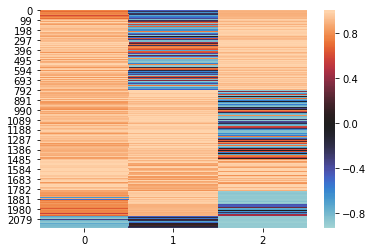

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 433
activations


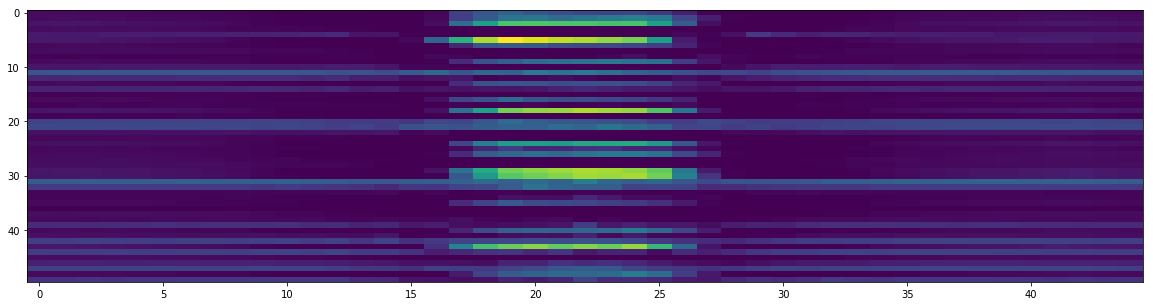

Task 0 hypothetical scores:


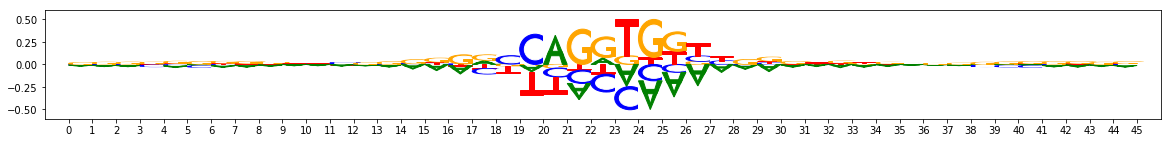

Task 0 actual importance scores:


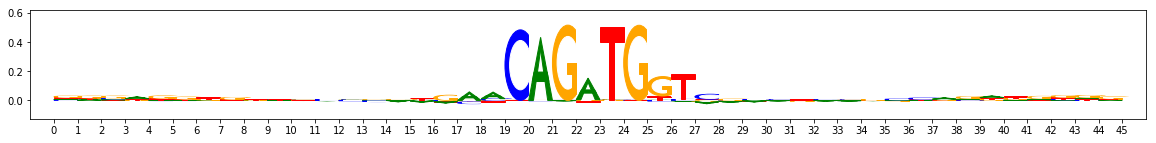

Task 1 hypothetical scores:


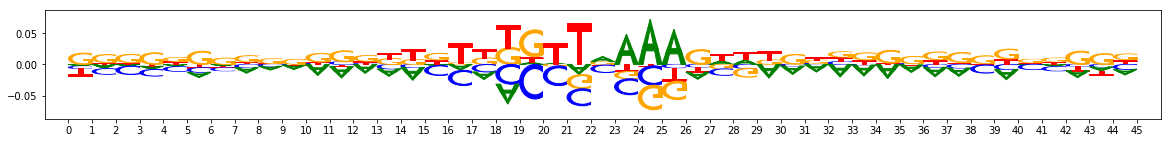

Task 1 actual importance scores:


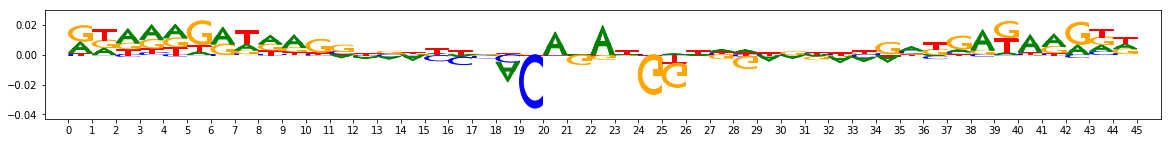

Task 2 hypothetical scores:


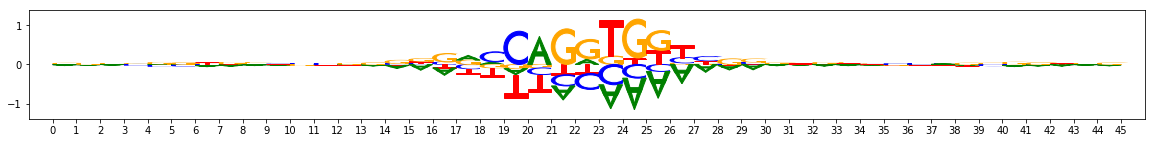

Task 2 actual importance scores:


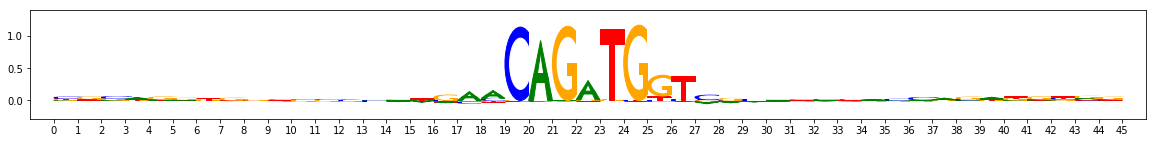

onehot, fwd and rev:


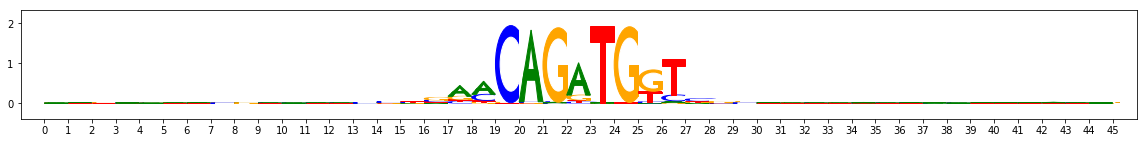

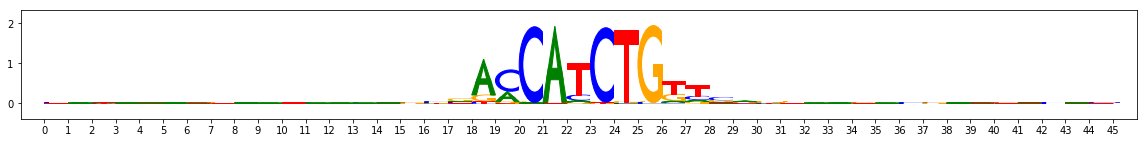

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 353
activations


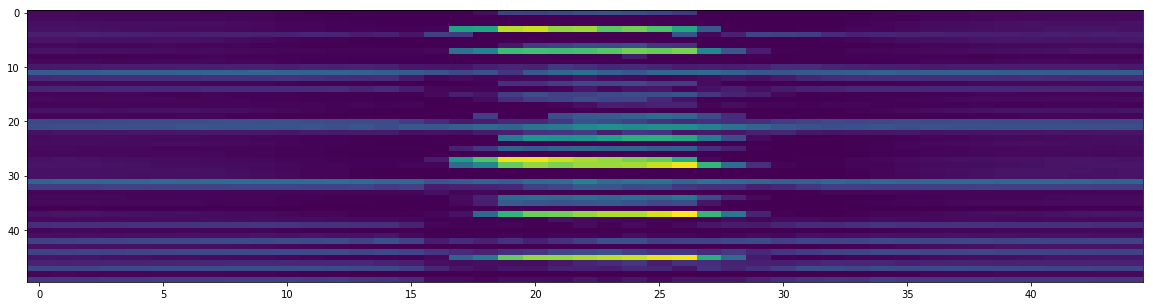

Task 0 hypothetical scores:


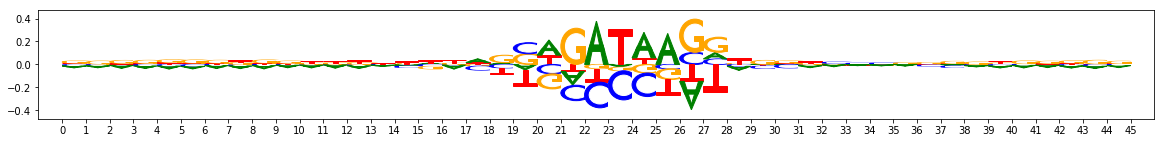

Task 0 actual importance scores:


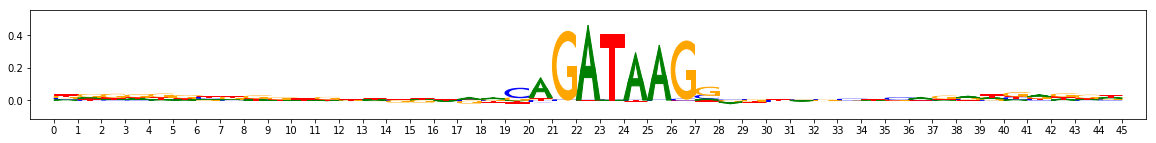

Task 1 hypothetical scores:


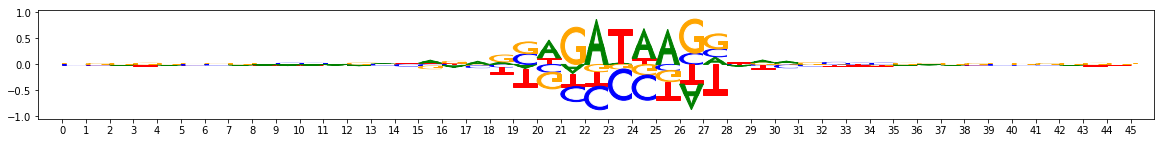

Task 1 actual importance scores:


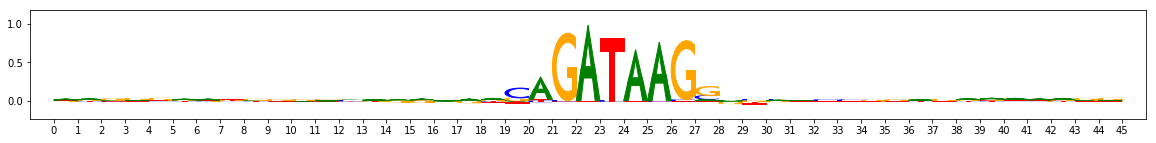

Task 2 hypothetical scores:


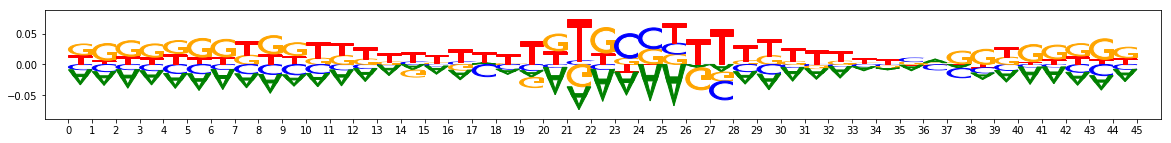

Task 2 actual importance scores:


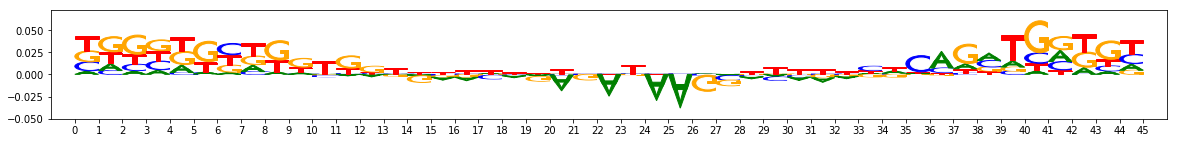

onehot, fwd and rev:


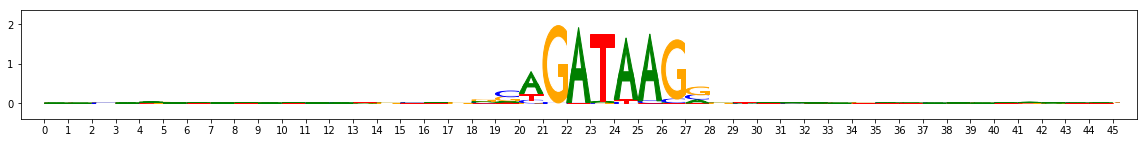

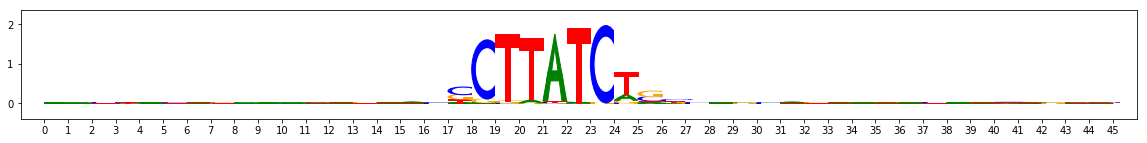

metacluster_2
activity pattern: [1 1 1]
metacluster_2 pattern_0
total seqlets: 167
activations


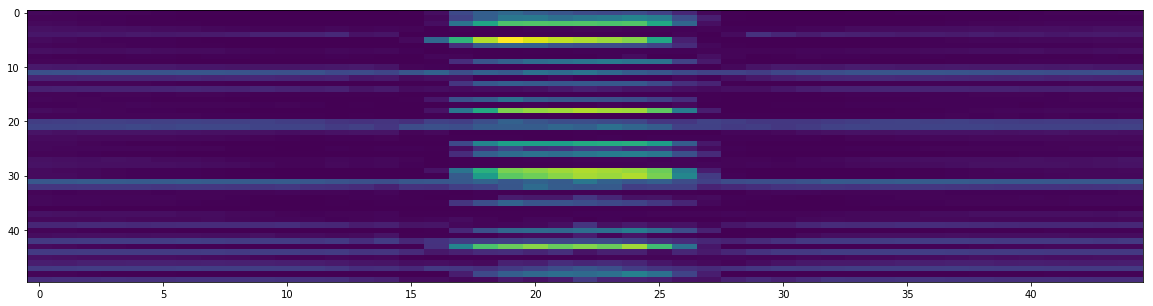

Task 0 hypothetical scores:


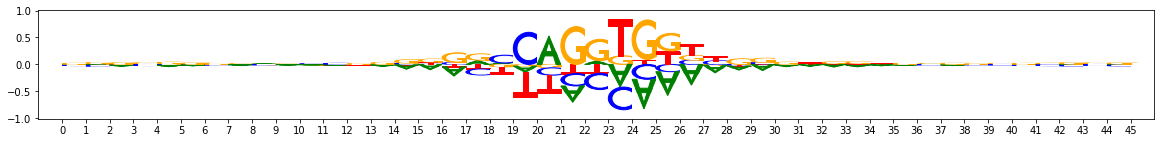

Task 0 actual importance scores:


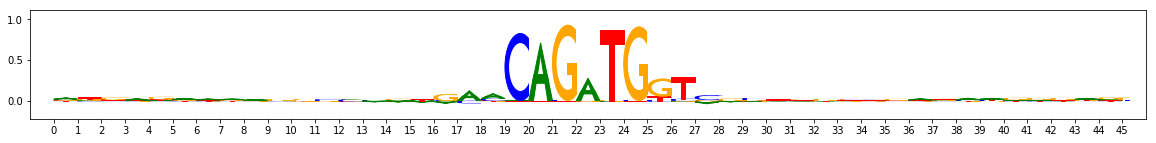

Task 1 hypothetical scores:


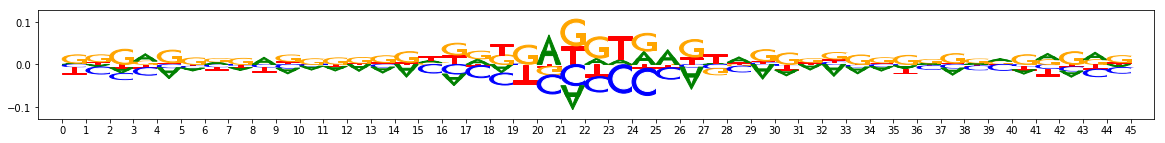

Task 1 actual importance scores:


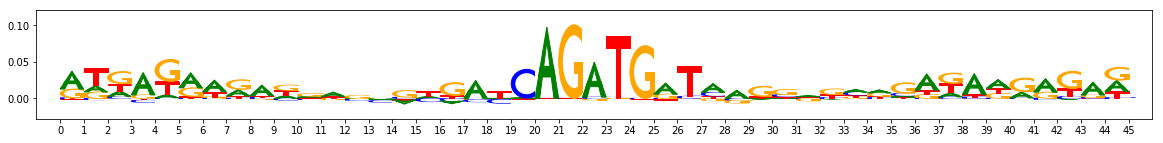

Task 2 hypothetical scores:


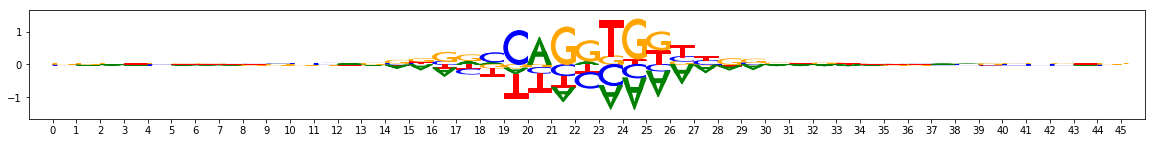

Task 2 actual importance scores:


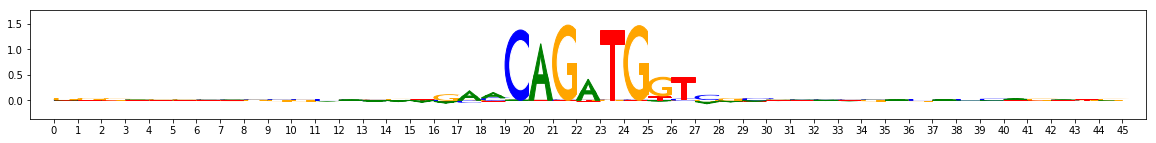

onehot, fwd and rev:


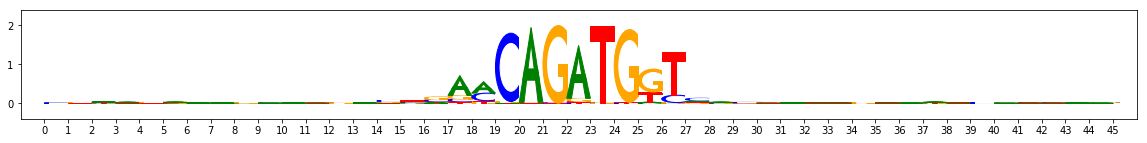

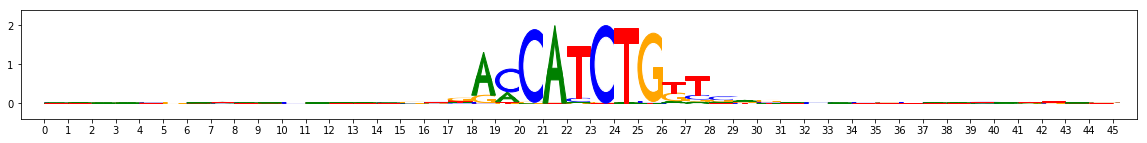

metacluster_2 pattern_1
total seqlets: 67
activations


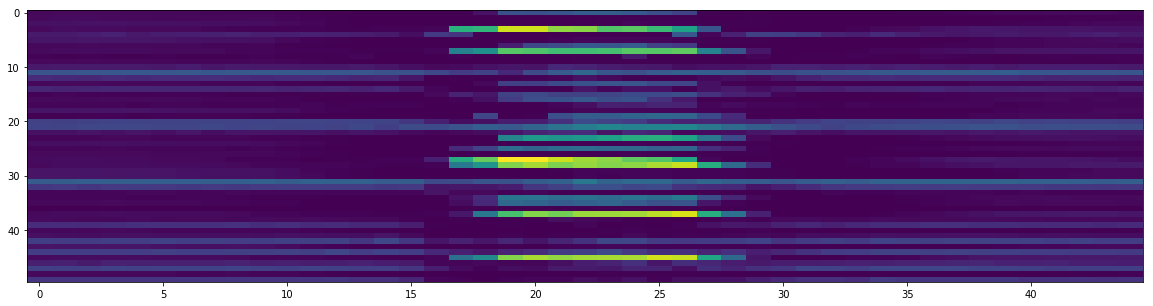

Task 0 hypothetical scores:


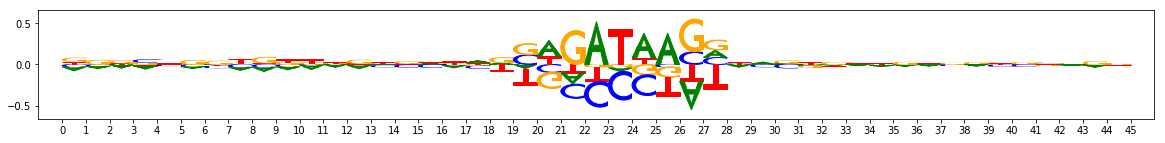

Task 0 actual importance scores:


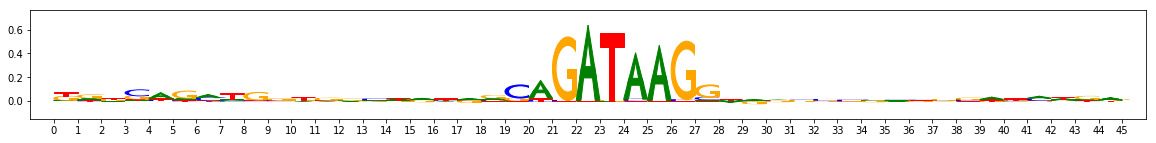

Task 1 hypothetical scores:


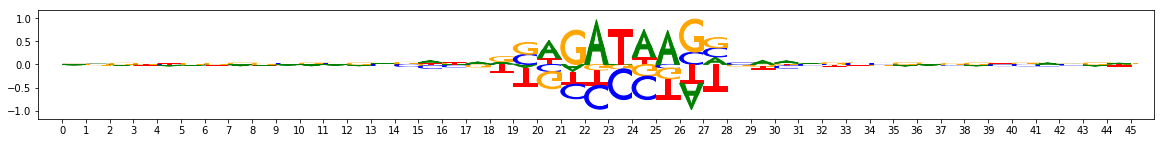

Task 1 actual importance scores:


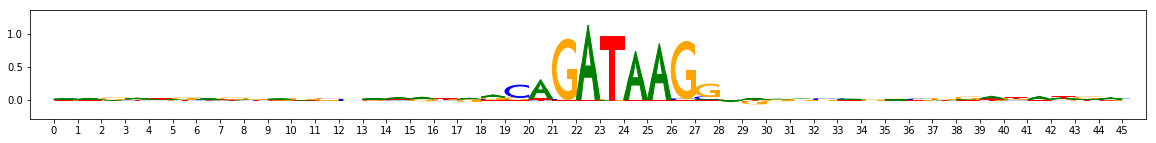

Task 2 hypothetical scores:


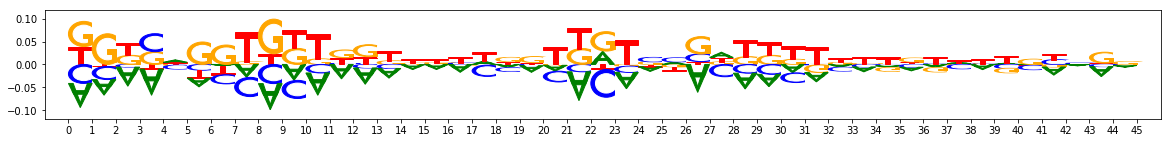

Task 2 actual importance scores:


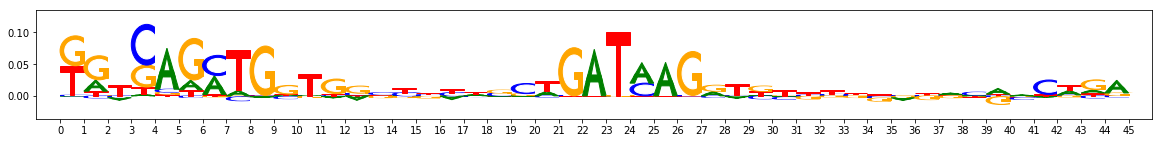

onehot, fwd and rev:


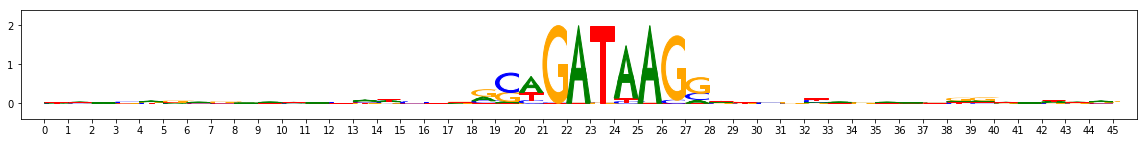

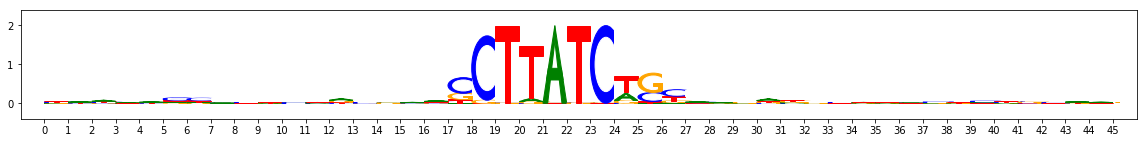

metacluster_3
activity pattern: [ 0  1 -1]
metacluster_3 pattern_0
total seqlets: 89
activations


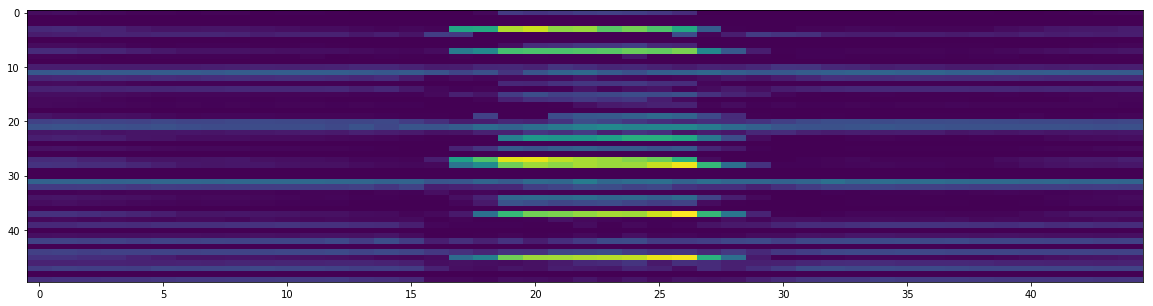

Task 0 hypothetical scores:


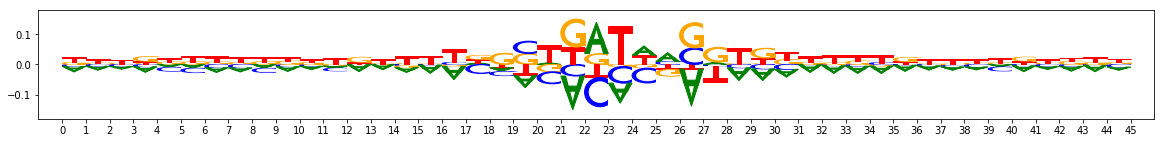

Task 0 actual importance scores:


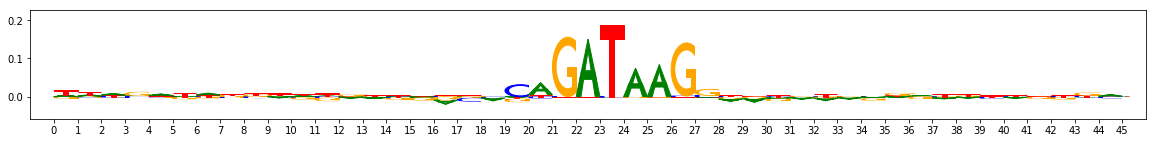

Task 1 hypothetical scores:


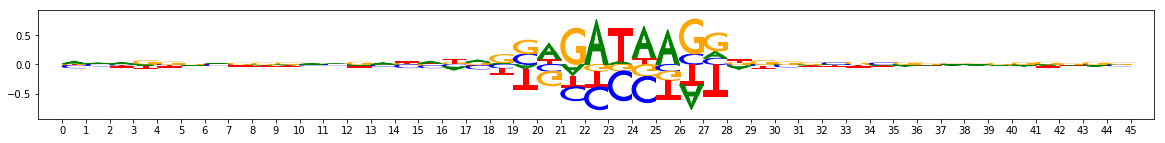

Task 1 actual importance scores:


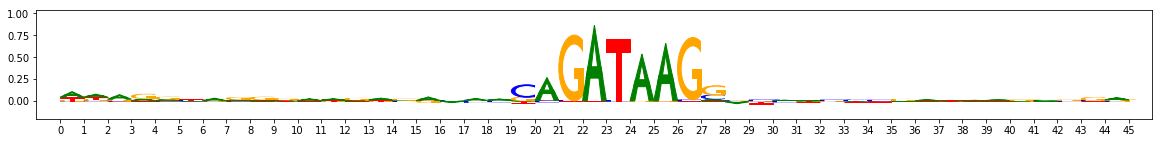

Task 2 hypothetical scores:


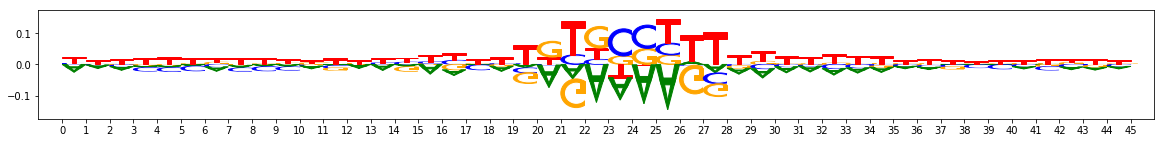

Task 2 actual importance scores:


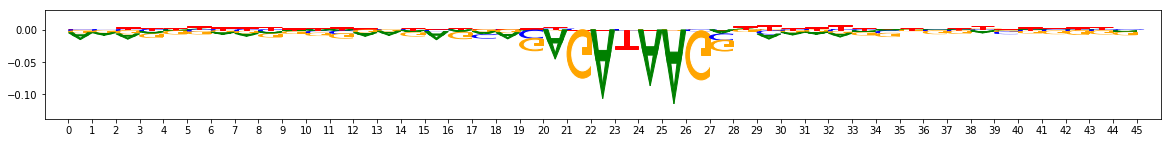

onehot, fwd and rev:


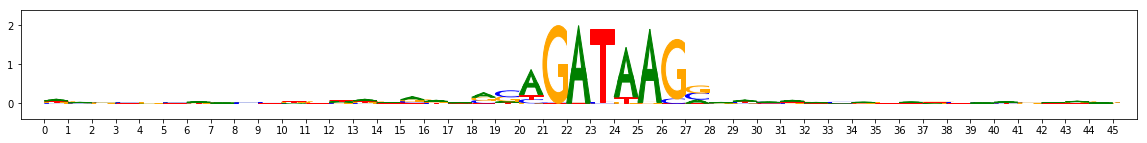

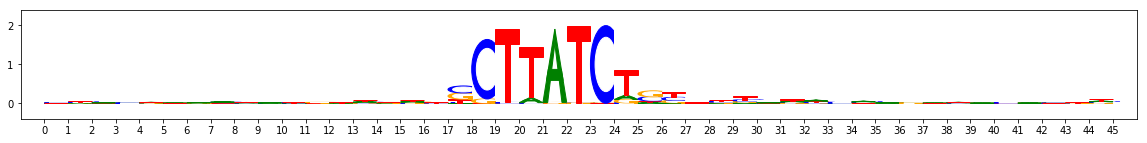

metacluster_4
activity pattern: [0 1 0]
metacluster_4 pattern_0
total seqlets: 72
activations


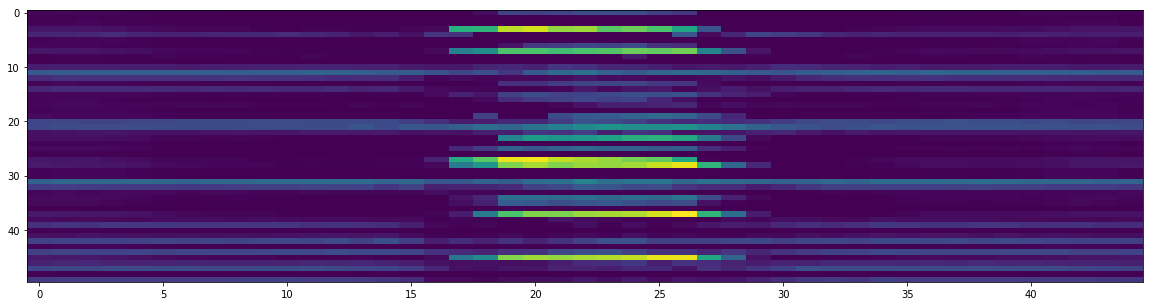

Task 0 hypothetical scores:


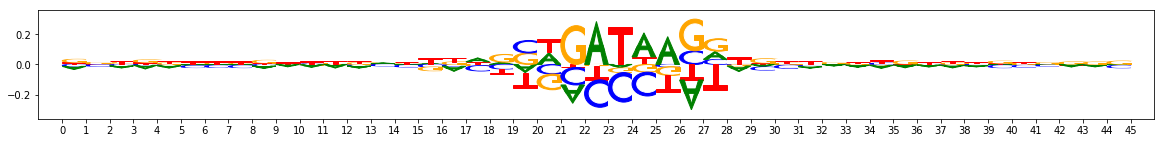

Task 0 actual importance scores:


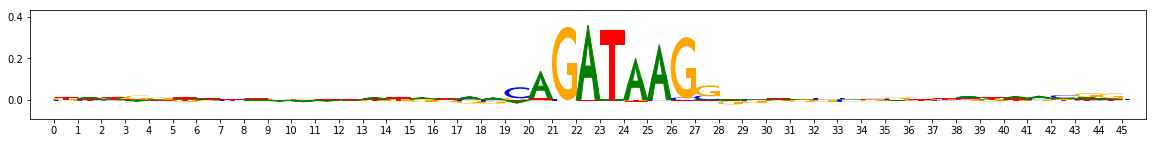

Task 1 hypothetical scores:


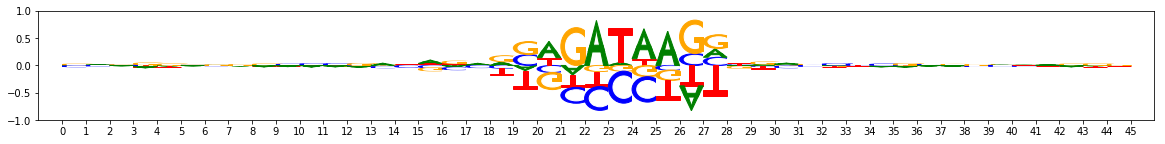

Task 1 actual importance scores:


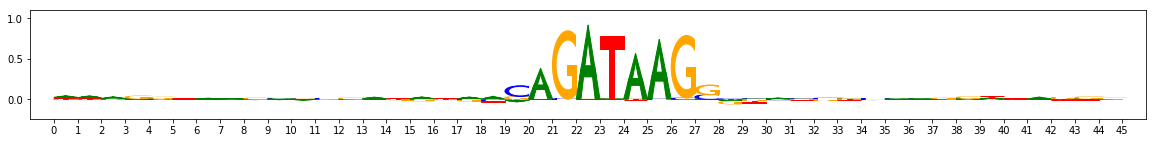

Task 2 hypothetical scores:


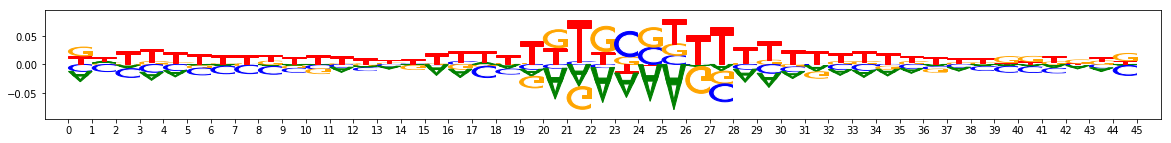

Task 2 actual importance scores:


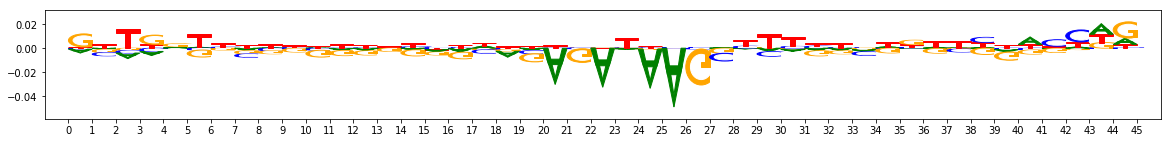

onehot, fwd and rev:


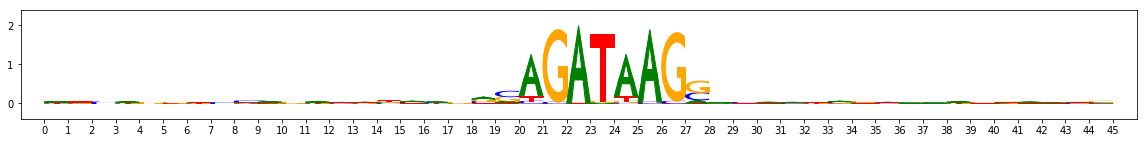

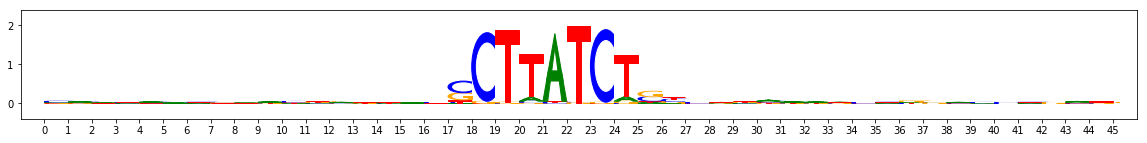

metacluster_5
activity pattern: [ 0  0 -1]
No motifs found for this activity pattern


In [29]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("activations")
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(np.array(pattern["activations"]["fwd"]).transpose(1,0))
        ax.set_aspect('auto')
        plt.show()
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()